In [1]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
df_ = pd.read_csv('C:ethusd30min.csv')
df = df_.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2020-01-10 00:00:00,137.73,137.98,137.60,137.64,5085.18940,1578616199999,7.008233e+05,2328,3417.37747,4.709823e+05,0
2020-01-10 00:30:00,137.63,137.68,137.05,137.16,4624.33459,1578617999999,6.348057e+05,2072,2552.69910,3.504246e+05,0
2020-01-10 01:00:00,137.17,137.42,136.84,136.91,2869.37376,1578619799999,3.934895e+05,1947,1634.72623,2.241945e+05,0
2020-01-10 01:30:00,136.92,137.07,136.72,136.90,2781.83043,1578621599999,3.807914e+05,1855,1698.23983,2.324746e+05,0
2020-01-10 02:00:00,136.91,137.18,136.67,137.15,4184.35055,1578623399999,5.731207e+05,1902,2771.27269,3.795864e+05,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14 22:00:00,4054.46,4074.00,4026.31,4072.16,14604.54301,1621031399999,5.906900e+07,36362,6917.29800,2.798067e+07,0
2021-05-14 22:30:00,4071.32,4109.21,4065.80,4073.01,18429.48971,1621033199999,7.533654e+07,45452,9435.72226,3.857310e+07,0
2021-05-14 23:00:00,4073.01,4110.12,4061.67,4077.09,12134.21618,1621034999999,4.960752e+07,23196,6021.61594,2.462237e+07,0


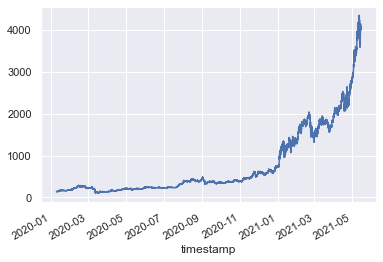

In [4]:
df.close.plot()

In [240]:
buyratio = df.tb_base_av/df.volume
buyratio

timestamp
2020-01-10 00:00:00    0.672026
2020-01-10 00:30:00    0.552014
2020-01-10 01:00:00    0.569715
2020-01-10 01:30:00    0.610476
2020-01-10 02:00:00    0.662295
                         ...   
2021-05-14 22:00:00    0.473640
2021-05-14 22:30:00    0.511990
2021-05-14 23:00:00    0.496251
2021-05-14 23:30:00    0.444956
2021-05-15 00:00:00    0.460437
Length: 23511, dtype: float64

In [242]:
buyratio = 100*df.tb_base_av/df.volume

# features
feature = pd.DataFrame()
mom_windows = [1,5,10,20]
for n in mom_windows:
    feature['p_mom_{}'.format(n)] = df.close.pct_change(n)
    feature['v_mom_{}'.format(n)] = np.log(df.volume).pct_change(n)
    feature['br_mom_{}'.format(n)] = (100*buyratio).pct_change(n)
    
std_windows = [12,48]
for n in std_windows:
    feature['p_std_{}'.format(n)] = df.close.rolling(n).std()
    feature['v_std_{}'.format(n)] = np.log(df.volume).rolling(n).std()
    feature['br_std_{}'.format(n)] = buyratio.rolling(n).std()
    
sma_windows = [10,60]
for n in sma_windows:
    feature['br_sma_{}'.format(n)] = buyratio.rolling(n).mean()

C:\Users\JHCho\anaconda3\envs\py37\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [243]:
feature.dropna(inplace=True)

In [244]:
corr = feature.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,p_mom_1,v_mom_1,bv_mom_1,p_mom_5,v_mom_5,bv_mom_5,p_mom_10,v_mom_10,bv_mom_10,p_mom_20,v_mom_20,bv_mom_20,p_std_12,v_std_12,bv_std_12,p_std_48,v_std_48,bv_std_48,bv_sma_10,bv_sma_60
p_mom_1,1.00,-0.03,0.26,0.43,-0.01,0.22,0.30,-0.01,0.23,0.22,-0.01,0.22,0.00,0.00,-0.01,0.01,0.01,-0.01,0.09,0.04
v_mom_1,-0.03,1.00,-0.04,-0.01,0.42,-0.01,-0.01,0.36,-0.01,-0.01,0.32,-0.01,-0.02,-0.01,0.03,-0.01,-0.01,0.01,0.00,0.00
bv_mom_1,0.26,-0.04,1.00,0.01,-0.01,0.46,0.00,-0.02,0.44,0.00,-0.02,0.44,-0.02,0.01,0.06,-0.02,0.01,0.05,-0.03,-0.01
p_mom_5,0.43,-0.01,0.01,1.00,-0.03,0.14,0.69,-0.02,0.14,0.48,-0.01,0.13,-0.00,-0.01,-0.01,0.02,0.01,-0.01,0.25,0.10
v_mom_5,-0.01,0.42,-0.01,-0.03,1.00,-0.04,-0.01,0.56,-0.01,-0.01,0.47,-0.01,-0.00,0.07,0.06,-0.02,0.01,0.03,0.01,0.01
bv_mom_5,0.22,-0.01,0.46,0.14,-0.04,1.00,0.01,-0.02,0.48,0.00,-0.02,0.45,-0.02,0.01,0.06,-0.02,0.02,0.05,-0.04,-0.02
p_mom_10,0.30,-0.01,0.00,0.69,-0.01,0.01,1.00,-0.03,0.11,0.68,-0.02,0.10,-0.00,-0.03,-0.01,0.02,0.01,-0.02,0.38,0.15
v_mom_10,-0.01,0.36,-0.02,-0.02,0.56,-0.02,-0.03,1.00,-0.04,-0.01,0.53,-0.02,0.07,0.18,0.05,-0.03,0.05,0.03,0.01,0.01
bv_mom_10,0.23,-0.01,0.44,0.14,-0.01,0.48,0.11,-0.04,1.00,0.00,-0.01,0.46,-0.02,0.02,0.07,-0.02,0.02,0.05,0.18,-0.02
p_mom_20,0.22,-0.01,0.00,0.48,-0.01,0.00,0.68,-0.01,0.00,1.00,-0.02,0.08,-0.02,-0.06,-0.00,0.03,-0.00,-0.02,0.32,0.24


In [251]:
sma5_direction = np.sign(df.close.rolling(5).mean().shift(-1).diff().dropna())

In [252]:
y = sma5_direction.copy()

In [253]:
y.loc[y==0] = 1.0

In [254]:
len(y)

23506

In [255]:
tmp = feature.join(y).dropna()
X = tmp.iloc[:,:-1]
y = tmp.iloc[:,-1]

X_train = X.iloc[:-3000]
X_test = X.iloc[-3000:]

y_train = y.iloc[:-3000]
y_test = y.iloc[-3000:]

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [261]:
# scaling은 트레인 테스트 나누어야함.

scaler = StandardScaler()
feature_scaled_train = scaler.fit_transform(X_train)
feature_scaled_train = pd.DataFrame(feature_scaled_train,
                          index=X_train.index, columns=X_train.columns)

# feature preprocess

In [320]:
#for i in feature_scaled_train.columns:
#    plt.figure()
#    plt.plot(feature_scaled_train[i])
#    plt.title(i)
#    plt.show()

In [295]:
pca = PCA(5)
X_train_pc = pca.fit_transform(feature_scaled_train)
X_train_pc = pd.DataFrame(X_train_pc,index=X_train.index,columns=['pc_{}'.format(i) for i in range(0,n_components_)])

In [321]:
#for i in X_train_pc.columns:
#    plt.figure()
#    plt.plot(X_train_pc[i])
#    plt.title(i)
#    plt.show()

In [265]:
components_ = pca.components_
n_components_ = pca.n_components_
explained_variance_ratio_ = pca.explained_variance_ratio_

Train&test

In [269]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge

clf = RandomForestClassifier()

In [206]:
#RF

from sklearn.model_selection import GridSearchCV
n_estimators = [500,1000]
max_depth = [2, 5]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth)
gs = GridSearchCV(clf, param_grid = param_grid, scoring ='precision')

In [207]:
#gs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5], 'n_estimators': [500, 1000]},
             scoring='precision')

In [212]:
#gs.best_params_

{'max_depth': 5, 'n_estimators': 1000}

In [270]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=5) #I'll skip Gridsearch
clf.fit(X_train_pc,y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000)

In [334]:
# test feature preprocess

scaler = StandardScaler()
feature_scaled_test = scaler.fit_transform(X_test)
feature_scaled_test = pd.DataFrame(feature_scaled_test,
                          index=X_test.index, columns=X_test.columns)

pca = PCA(5)
X_test_pc = pca.fit_transform(feature_scaled_test)
X_test_pc = pd.DataFrame(X_test_pc,index=X_test.index,columns=['pc_{}'.format(i) for i in range(0,n_components_)])

In [273]:
y_pred = clf.predict(X_test_pc)
y_pred = pd.Series(y_pred, index=X_test.index).rename('y_pred')

In [274]:
from sklearn.metrics import precision_score, accuracy_score
p = precision_score(y_test, y_pred)
a = accuracy_score(y_test, y_pred)

In [333]:
print('Precision Score: {}'.format(p.round(4)))
print('Accuracy Score: {}'.format(a.round(4)))

Precision Score: 0.7003
Accuracy Score: 0.6967


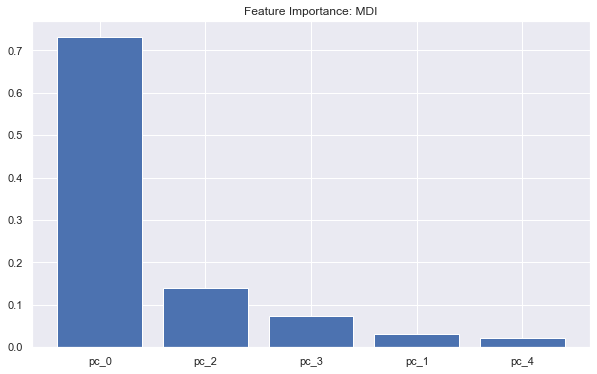

In [310]:
mdi = pd.DataFrame(clf.feature_importances_, columns = ['MDI'], index = X_test_pc.columns).sort_values('MDI', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(mdi.index, mdi.MDI)
plt.title("Feature Importance: MDI")
plt.show()

In [322]:
#n_loadings = n_components_
#fig, axs = plt.subplots(n_loadings, 1, sharex=True, figsize=(15, 10))
#for i in range(n_loadings):
#        axs[i].bar([i for i in feature.columns],
#                    components_[i])
#        axs[i].set_ylabel('component '+str(i)+' loading',
#                            fontsize=10)
#axs[0].set_title('PCA Loadings', fontsize=10)
#axs[i].set_xlabel('Features', fontsize=10)
#
#fig.tight_layout()

In [328]:
# most important pc

corr_mi_pc = X_train.join(X_train_pc['pc_0']).corr().iloc[:,-1].sort_values().to_frame()

In [329]:
corr_mi_pc

,pc_0
p_mom_10,-0.689162
p_mom_5,-0.680971
p_mom_20,-0.583892
p_mom_1,-0.572895
bv_mom_20,-0.558084
bv_mom_10,-0.542718
bv_sma_10,-0.471710
bv_mom_5,-0.471126
bv_mom_1,-0.434349
bv_sma_60,-0.228522
